## 1 Python Configuration and Data Loading


Please follow the instructions below to ensure your Python environment is configured properly, and you are able to successfully load the data provided with this homework.

In [62]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
from scipy import io
for data_name in ["mnist", "spam", "cifar10"]:
    data = io.loadmat("data/%s_data.mat" % data_name)
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)

loaded cifar10 data!
test_data (10000, 3072)
training_data (50000, 3072)
training_labels (50000, 1)


## 2 Data Partitioning

Create a function to shuffle the whole dataset

In [53]:
import random
def shuffle_dataset(name):
    dataset = io.loadmat(f"data/{name}")
    training_data = dataset["training_data"]
    training_lable = dataset["training_labels"]
    dataset_size = training_data.shape[0]
    reindex = random.sample(range(dataset_size), dataset_size)
    return training_data[reindex], training_lable[reindex]

For the MNIST dataset, write code that sets aside 10,000 training images as a validation set.

In [55]:
# Shuffle the dataset
minist_training_data, minist_training_label = shuffle_dataset("mnist_data.mat")
minist_validation_X = minist_training_data[:10000]
minist_validation_y = minist_training_label[:10000]
minist_training_data = minist_training_data[10000:]
minist_training_label = minist_training_label[10000:]

For the spam dataset, write code that sets aside 20% of the training data as a validation set.

In [56]:
spam_training_data, spam_training_label = shuffle_dataset("spam_data.mat")
validation_rows = int(spam_training_data.shape[0] * 0.2)
spam_validation_X = spam_training_data[:validation_rows]
spam_validation_y = spam_training_label[:validation_rows]
spam_training_data = spam_training_data[validation_rows:]
spam_training_label = spam_training_label[validation_rows:]

For the CIFAR-10 dataset, write code that sets aside 5,000 training images as a validation set.

In [57]:
cifar_training_data, cifar_training_label = shuffle_dataset("cifar10_data.mat")
cifar_validation_X = cifar_training_data[:5000]
cifar_validation_y = cifar_training_label[:5000]
cifar_training_data = cifar_training_data[5000:]
cifar_training_label = cifar_training_label[5000:]

## 3 Support Vector Machines: Coding

We will use linear Support Vector Machines to classify our datasets. For images, we will use the simplest of features for classification: raw pixel brightness values. In other words, our feature vector for an image will be a row vector with all the pixel values concatenated in a row major (or column major) order.

In [109]:
def calculate_accuracy(training_data, training_label, validation_data, validation_label ,training_sizes):
    svm_model = sklearn.svm.SVC(kernel='linear')
    training_accuracy = []
    validation_accuracy = []
    for train_size in training_sizes:
        svm_model.fit(training_data[:train_size], training_label[:train_size].ravel())
        
        predict_training = svm_model.predict(training_data[:train_size])
        training_accuracy.append(sklearn.metrics.accuracy_score(predict_training, training_label[:train_size]))
        
        predict_validation = svm_model.predict(validation_data)
        validation_accuracy.append(sklearn.metrics.accuracy_score(predict_validation, validation_label.ravel()))
    return training_accuracy, validation_accuracy

In [108]:
def plot_accuracy(training_sizes,training_accuarcy, validation_accuracy, title):
    plt.plot(training_sizes, training_accuarcy, label="training accuracy", marker="*")
    plt.plot(training_sizes, validation_accuracy, label="validation accuracy", marker="*")
    plt.xlabel('number of training examples')
    plt.ylabel('accuracy')
    plt.title(f"{title} accuracy on the training and validation sets versus the number of training examples")
    plt.legend()

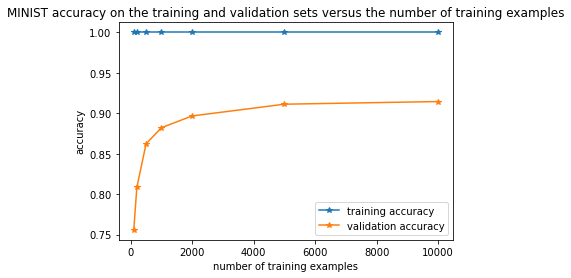

In [110]:
minist_training_accuracy, minist_validation_accuracy = calculate_accuracy(minist_training_data, minist_training_label, minist_validation_X, minist_validation_y, \
                   [100, 200, 500, 1000, 2000, 5000, 10000])
plot_accuracy([100, 200, 500, 1000, 2000, 5000, 10000], minist_training_accuracy, minist_validation_accuracy, "MINIST")

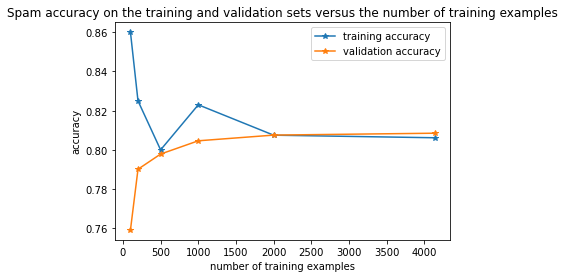

In [111]:
spam_training_accuracy, spam_validation_accuracy = calculate_accuracy(spam_training_data, spam_training_label, spam_validation_X, spam_validation_y,\
                                                                     [100, 200, 500, 1000, 2000, spam_training_data.shape[0]])
plot_accuracy([100, 200, 500, 1000, 2000, spam_training_data.shape[0]], spam_training_accuracy, spam_validation_accuracy, "Spam")

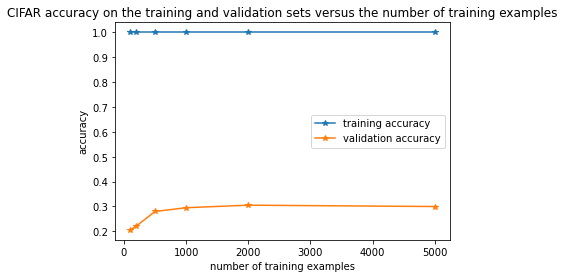

In [113]:
cifar_training_accuracy, cifar_validation_accuracy = calculate_accuracy(cifar_training_data, cifar_training_label, cifar_validation_X, cifar_validation_y,\
                                                                       [100, 200, 500, 1000, 2000, 5000])
plot_accuracy([100, 200, 500, 1000, 2000, 5000], cifar_training_accuracy, cifar_validation_accuracy, "CIFAR")

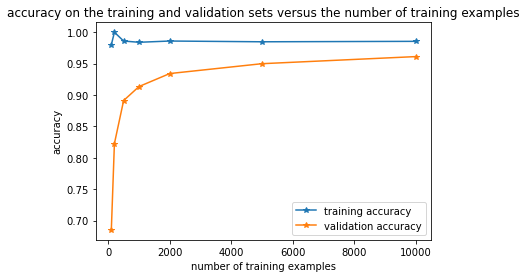